In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from gensim.models import KeyedVectors
import matplotlib.font_manager as fm
from sklearn.manifold import TSNE
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors

import sys
from pathlib import Path

# Add the project root directory to Python path
project_root = str(Path().absolute().parent)
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.utils import load_models

import matplotlib.pyplot as plt
# 设置更好的可视化风格

# 设置更好的可视化风格
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)
sns.set_style("whitegrid")
# 假设notebooks目录在项目根目录下


from src.utils import download_chinese_font
import src.utils as utils
# 下载并安装字体
font_path = download_chinese_font()

# 设置matplotlib使用下载的字体
if font_path:
    plt.rcParams['font.sans-serif'] = ['SimHei'] + plt.rcParams['font.sans-serif']
    print("成功设置中文字体")
else:
    print("无法设置中文字体，将使用替代方案")

plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号


# 定义项目根目录和模型目录
PROJECT_ROOT = Path.cwd().parent
MODELS_DIR = PROJECT_ROOT / "models"



字体已存在: /home/fangshikai/.fonts/SimHei.ttf
刷新字体缓存...
成功设置中文字体


In [2]:
from clustering_analysis import ClusteringAnalyzer
    # 1. 初始化
try:
    models = utils.load_models(MODELS_DIR)
    output_dir = PROJECT_ROOT / "output" / "clustering_analysis"
    analyzer = ClusteringAnalyzer(models, output_dir)
except (ValueError, FileNotFoundError) as e:
    print(f"初始化分析器失败: {e}")



字体已存在: /home/fangshikai/.fonts/SimHei.ttf
刷新字体缓存...
成功设置中文字体
字体已存在: /home/fangshikai/.fonts/SimHei.ttf
刷新字体缓存...
成功设置中文字体
使用固定时期模型目录: /home/fangshikai/law-word-vector/models/fine_tuned_vectors_flexible
找到 3 个模型文件:
  加载模型: Era1_1978-1996
  成功加载 Era1_1978-1996, 词汇量: 4874
  加载模型: Era2_1997-2013
  成功加载 Era2_1997-2013, 词汇量: 4992
  加载模型: Era3_2014-2024
  成功加载 Era3_2014-2024, 词汇量: 5000

DimensionAnalyzer 初始化成功，共加载 3 个模型。
ClusteringAnalyzer 初始化成功，输出目录: /home/fangshikai/law-word-vector/output/clustering_analysis


加载 Era1_1978-1996: 150 个词
加载 Era2_1997-2013: 150 个词
加载 Era3_2014-2024: 150 个词
已加载 17 个排除词
Era1_1978-1996: 过滤后保留 149 个词
Era2_1997-2013: 过滤后保留 148 个词
Era3_2014-2024: 过滤后保留 148 个词
所有时期共有词: 41 个
所有时期词汇并集: 284 个

--- 开始对 284 个词进行 3-聚类 ---
使用 Era3_2014-2024 模型进行聚类
聚类1: 121 个词, 前10个: ['治理体系', '贯彻实施', '民法', '监督', '公信力', '法治', '治理能力', '立法法', '法律法规', '有法可依']
聚类2: 57 个词, 前10个: ['公正司法', '行使权力', '司法人员', '以言代法', '法理', '社会主义法治理论', '文明执法', '法治国家', '违法必究', '惩恶扬善']
聚类3: 55 个词, 前10个: ['化解矛盾', '自律', '法律手段', '宣传教育', '以案释法', '观念', '行为规范', '舆论监督', '厉行', '法制宣传']


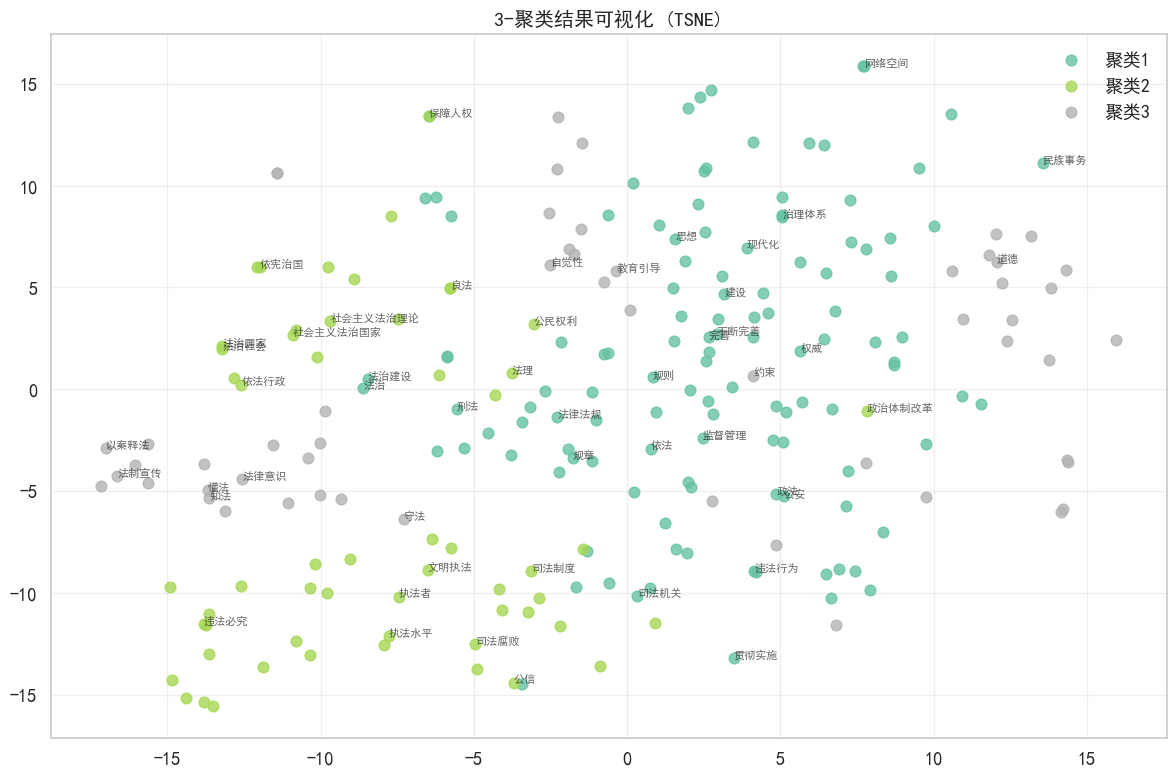

已保存聚类结果到: /home/fangshikai/law-word-vector/output/clustering_analysis/cluster_results_3d.txt
轮廓系数 (Silhouette Score): 0.047
Calinski-Harabasz 指数: 11.833

=== 分析完成 ===


In [3]:
# 2. 定义分析参数
era_files = {
    'Era1_1978-1996': 'similar_words/Era1_1978-1996_final.txt',
    'Era2_1997-2013': 'similar_words/Era2_1997-2013_final.txt',
    'Era3_2014-2024': 'similar_words/Era3_2014-2024_final.txt'
}

# 3. 运行分析
analyzer.analyze(
    era_files=era_files,
    cluster_numbers=[3, ],
    top_n=150,
    exclude_words_path="exclude_words.txt"
)

print("\n=== 分析完成 ===")